In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [12]:
import kagglehub

path = kagglehub.dataset_download("patrickfleith/nasa-battery-dataset")

print("Dataset path:", path)


Using Colab cache for faster access to the 'nasa-battery-dataset' dataset.
Dataset path: /kaggle/input/nasa-battery-dataset


In [13]:
import os
os.listdir(path)


['cleaned_dataset']

In [14]:
import pandas as pd

sample_file = data_path + "/00001.csv"
print(sample_file)
df= pd.read_csv(sample_file)

df.info()



/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/00001.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Voltage_measured      490 non-null    float64
 1   Current_measured      490 non-null    float64
 2   Temperature_measured  490 non-null    float64
 3   Current_load          490 non-null    float64
 4   Voltage_load          490 non-null    float64
 5   Time                  490 non-null    float64
dtypes: float64(6)
memory usage: 23.1 KB


In [15]:
import glob

data_path = "/kaggle/input/nasa-battery-dataset/cleaned_dataset/data"
files = sorted(glob.glob(data_path + "/*.csv"))

df = pd.read_csv(files[0])  # first discharge cycle


In [16]:
df = df[['Time',
         'Current_measured',
         'Voltage_measured',
         'Temperature_measured']]


In [17]:
# Nominal capacity in Ah
C_nom = 2.0

# Convert Time from seconds to hours
time_sec = df['Time'].values
time_hr = np.diff(time_sec, prepend=time_sec[0]) / 3600

# Current (discharge current is negative in dataset)
current = np.abs(df['Current_measured'].values)

# Coulomb counting
soc_actual = 1 - np.cumsum(current * time_hr) / C_nom

# Clamp between 0 and 1
soc_actual = np.clip(soc_actual, 0, 1)

df['SOC_actual'] = soc_actual


In [18]:
features = ['Current_measured', 'Voltage_measured', 'Temperature_measured']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])


In [19]:
def create_sequences(X, y, window=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

window_size = 10

X, y = create_sequences(X_scaled, df['SOC_actual'].values, window_size)


In [20]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [24]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1, activation='sigmoid')
])


model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0568 - mae: 0.1948 - val_loss: 0.0846 - val_mae: 0.2903
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0266 - mae: 0.1387 - val_loss: 0.1272 - val_mae: 0.3563
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0272 - mae: 0.1428 - val_loss: 0.0768 - val_mae: 0.2768
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0219 - mae: 0.1281 - val_loss: 0.0635 - val_mae: 0.2519
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0176 - mae: 0.1158 - val_loss: 0.0327 - val_mae: 0.1807
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0120 - mae: 0.0939 - val_loss: 0.0067 - val_mae: 0.0816
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085 - mae: 0.0734 - val_loss: 0.0030 - val_mae: 0.0546
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0078 - mae: 0.0677 - val_loss: 0.0024 - val_mae: 0.0481
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0074 - mae: 0.

In [25]:
soc_pred = model.predict(X_test).flatten()

# Evaluation
print("SOC MAE:", mean_absolute_error(y_test, soc_pred))
print("SOC RMSE:", np.sqrt(mean_squared_error(y_test, soc_pred)))
print("SOC R2:", r2_score(y_test, soc_pred))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
SOC MAE: 0.024372327186074783
SOC RMSE: 0.03110385184777774
SOC R2: 0.5408772158527361


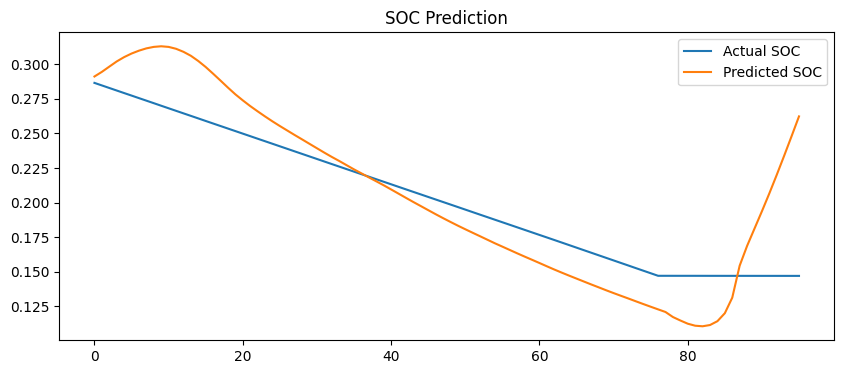

In [26]:
plt.figure(figsize=(10,4))
plt.plot(y_test, label='Actual SOC')
plt.plot(soc_pred, label='Predicted SOC')
plt.legend()
plt.title("SOC Prediction")
plt.show()


<Figure size 500x500 with 0 Axes>

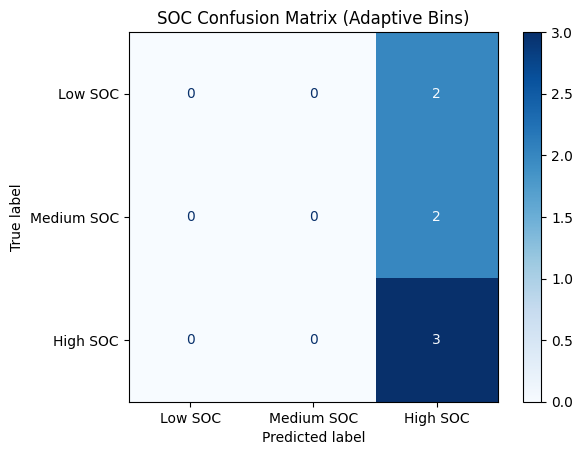

In [66]:
# Adaptive bins based on data distribution
bins = np.quantile(y_test_aligned, [0, 0.33, 0.66, 1.0])

def soc_to_class_auto(soc):
    if soc < bins[1]:
        return 0
    elif soc < bins[2]:
        return 1
    else:
        return 2

y_cls = np.array([soc_to_class_auto(v) for v in y_test_aligned])
p_cls = np.array([soc_to_class_auto(v) for v in soc_pred_aligned])

cm = confusion_matrix(y_cls, p_cls, labels=[0,1,2])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Low SOC', 'Medium SOC', 'High SOC']
)

plt.figure(figsize=(5,5))
disp.plot(cmap='Blues', values_format='d')
plt.title("SOC Confusion Matrix (Adaptive Bins)")
plt.show()


In [69]:
import numpy as np

# --- ALIGN LENGTHS ---
min_len = min(len(y_test), len(soc_pred))
y_true = y_test[:min_len]
y_pred = soc_pred[:min_len]

# --- SMAPE FUNCTION ---
def smape(y_true, y_pred, eps=1e-6):
    return np.mean(
        2 * np.abs(y_pred - y_true) /
        (np.abs(y_true) + np.abs(y_pred) + eps)
    )

print("SOC SMAPE:", smape(y_true, y_pred))


SOC SMAPE: 0.35144452088202044


  0%|          | 0/7 [00:00<?, ?it/s]

IndexError: list index out of range

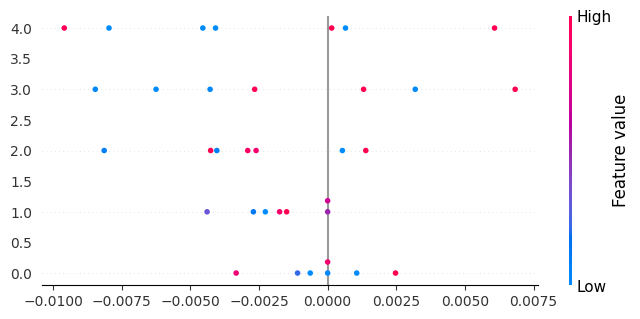

In [75]:
# ===============================
# SHAP FOR LSTM SOC MODEL (SAFE)
# ===============================

import shap
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# CONFIG
# -------------------------------
FEATURE_NAMES = ['Current', 'Voltage', 'Temperature']
N_BACKGROUND = min(30, X_train.shape[0])
N_TEST = min(20, X_test.shape[0])

# -------------------------------
# FLATTENING HELPERS
# -------------------------------
def flatten_3d(X):
    return X.reshape(X.shape[0], -1)

def unflatten_2d(X_flat, timesteps, features):
    return X_flat.reshape(X_flat.shape[0], timesteps, features)

TIMESTEPS = X_train.shape[1]
N_FEATURES = X_train.shape[2]

# -------------------------------
# BACKGROUND & TEST DATA
# -------------------------------
X_bg = flatten_3d(X_train[:N_BACKGROUND])
X_explain = flatten_3d(X_test[:N_TEST])

# -------------------------------
# MODEL PREDICTION WRAPPER
# -------------------------------
def model_predict_flat(X_flat):
    X_3d = unflatten_2d(X_flat, TIMESTEPS, N_FEATURES)
    return model.predict(X_3d, verbose=0).flatten()

# -------------------------------
# SHAP EXPLAINER (Kernel)
# -------------------------------
explainer = shap.KernelExplainer(
    model_predict_flat,
    X_bg
)

# -------------------------------
# SHAP VALUES
# -------------------------------
shap_values = explainer.shap_values(X_explain, nsamples=100)

# shap_values shape → (samples, timesteps*features)
shap_values = np.array(shap_values)

# -------------------------------
# AGGREGATE OVER TIME
# -------------------------------
# → (samples, features)
shap_agg = shap_values.reshape(
    shap_values.shape[0],
    TIMESTEPS,
    N_FEATURES
).mean(axis=1)

X_agg = X_explain.reshape(
    X_explain.shape[0],
    TIMESTEPS,
    N_FEATURES
).mean(axis=1)

# -------------------------------
# SHAP SUMMARY (BEESWARM)
# -------------------------------
shap.summary_plot(
    shap_agg,
    X_agg,
    feature_names=FEATURE_NAMES,
    show=True
)

# -------------------------------
# SHAP BAR (GLOBAL IMPORTANCE)
# -------------------------------
shap.summary_plot(
    shap_agg,
    X_agg,
    feature_names=FEATURE_NAMES,
    plot_type="bar",
    show=True
)
